In [1]:
import pandas as pd
import numpy as np
import re
import zipcodes
import matplotlib.pyplot as plt 

final_df = pd.DataFrame()

read_list = ['MA_Exer_PikesPeak_Males.txt', 'MA_Exer_PikesPeak_Females.txt']

for file in read_list: 
    test = pd.read_table(file, sep = r'" "|\t', engine='python')


    class curation_functions():
        # Corrects datetime issues for total seconds calculations
        def adder(data):
            data = ''.join(re.findall("\d+|:", data.strip()))
            if len(data) <= 5:
                data = str('00:') + str(data)
                return data
            else: 
                data = data.zfill(8)
                return data

        # Finds incorrect states based on city (North Bethesda was not a city included in the zipcodes package)
        def state_finder(data_1, data_2):
            try: 
                if (len(str(data_2)) != 2) & (str(data_1) != 'North Bethesda'):
                    return zipcodes.filter_by(city=str(data_1))[0]['state']
                elif str(data_1) == 'North Bethesda':
                    return 'MD'
                else:
                    return data_2
            except:
                return 'No State'

        def city_state(data):
            if len(data.split(' ')) == 2:
                try: 
                        city = data.replace('.', '').split(' ')[0]
                except: 
                    city = 'No City'
                try: 
                    state = data.replace('.', '').split(' ')[1]
                except: 
                    state = 'No State'
            else: 
                try: 
                        city = data.replace('.', '').split(' ')[0] + ' ' + data.replace('.', '').split(' ')[1]
                except: 
                    city = 'No City'
                try: 
                    state = data.replace('.', '').split(' ')[2]
                except: 
                    state = 'No State'
            return city, state

    # Converts times to total seconds 
    test['Net Tim'] = pd.to_timedelta(test['Net Tim'].apply(curation_functions.adder)).dt.total_seconds()
    test['Gun Tim'] = pd.to_timedelta(test['Gun Tim'].apply(curation_functions.adder)).dt.total_seconds()
    test['Pace'] = pd.to_timedelta(test['Pace'].apply(curation_functions.adder)).dt.total_seconds()

    ## Imputes missing values for Ag with only +- 10 Paces
    test['Ag'][test['Ag'].isnull()] = test['Ag'][(test['Pace'] >= (test['Pace'][test['Ag'].isnull()].mean() - 10)) & (test['Pace'] <= (test['Pace'][test['Ag'].isnull()].mean() + 10))].mean()
    test['Div/Tot'] = test['Div/Tot'].fillna('0/0')

    # splits div and tot
    test['Div'] = test['Div/Tot'].apply(lambda x: float(str(x).split(r'/')[0]))
    test['Tot'] = test['Div/Tot'].apply(lambda x: float(str(x).split(r'/')[1]))

    # computes time diff
    test['time_diff'] = test['Gun Tim'] - test['Net Tim']


    # derives city, state
    testing = test['Hometown'].apply(curation_functions.city_state)
    city = []
    [city.append(i[0]) for i in testing]

    state = []
    [state.append(i[1]) for i in testing]

    test['city'] = city
    test['state'] = state

    test['state'] = test.apply(lambda x: curation_functions.state_finder(x['city'], x['state']), axis = 1)
    test['state'] = np.where(test['state'] == '', test['city'], test['state'])
    test['gender'] = file.split('_')[3].split('.')[0]

    test.columns = ['place', 'div_tot', 'num', 'name', 'age', 'hometown', 'gun_time', 'net_time', 'pace', 'div', 'tot', 'time_diff', 'city', 'state', 'gender']
    
    final_df = pd.concat([final_df, test])
    
    print(file)
    

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MA_Exer_PikesPeak_Males.txt


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MA_Exer_PikesPeak_Females.txt


# Overaly Analysis

### Theoretically, these gun_time and net_time should have the same values (Assuming a perfect conditions). As the overlays show the net_times demonstrate a slightly larger increase in overall times (indicated by the increases of the bins to the left)

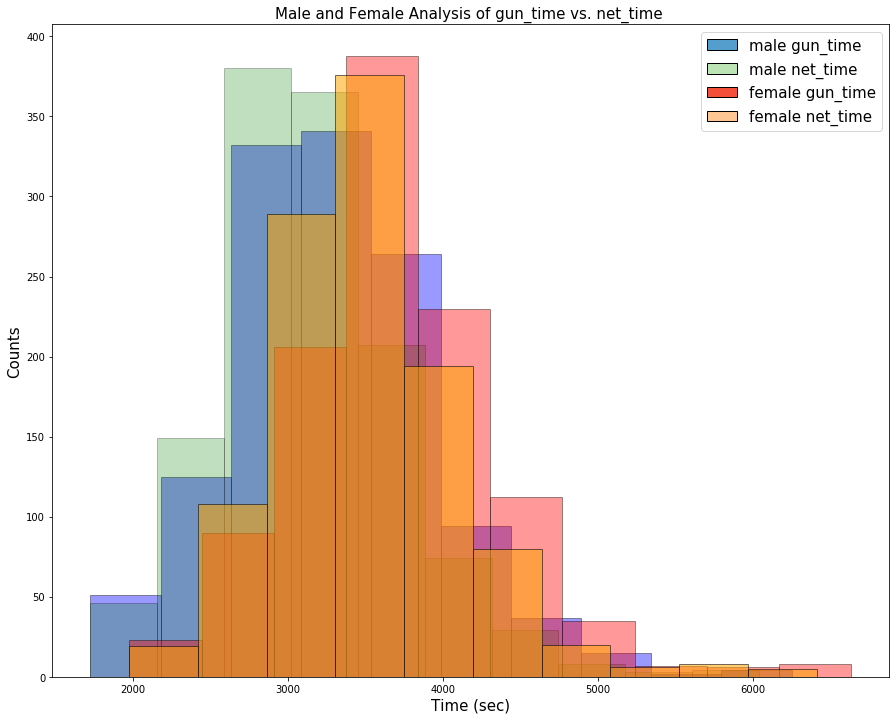

In [1088]:
##### from matplotlib.patches import Rectangle

cmap = plt.get_cmap('Blues', 8)
male_gun_time = cmap(0.5)
cmap = plt.get_cmap('Greens', 8)
male_net_time =cmap(0.25)

cmap = plt.get_cmap('Reds', 8)
female_gun_time = cmap(0.5)
cmap = plt.get_cmap('Oranges', 8)
female_net_time =cmap(0.25)

counts, bins = np.histogram(final_df['gun_time'][final_df.gender == 'Males'], bins=20)
mode = dict(zip(bins, counts))
left_mode = list(sorted(mode.items(),key= lambda x:x[1]))[-1]
modez = float(left_mode[0])
plt.rcParams ["figure.figsize"] = (15, 12) 
plt.hist(final_df['gun_time'][final_df.gender == 'Males'], alpha = 0.40, bins = 10, color = 'blue', edgecolor = 'black')
plt.hist(final_df['net_time'][final_df.gender == 'Males'], alpha = 0.25, bins = 10, color = 'green', edgecolor = 'black')

plt.hist(final_df['gun_time'][final_df.gender == 'Females'], alpha = 0.4, bins = 10, color = 'red', edgecolor = 'black')
plt.hist(final_df['net_time'][final_df.gender == 'Females'], alpha = 0.55, bins = 10, color = 'orange', edgecolor = 'black')

plt.title(str('Male and Female') + str(" Analysis of gun_time vs. net_time "), fontsize = 15)
plt.xlabel('Time (sec)', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [male_gun_time, male_net_time, female_gun_time, female_net_time]]
labels= ['male gun_time', 'male net_time','female gun_time', 'female net_time']
plt.legend(handles, labels, fontsize = 15)

# Mean, Median, Mode Analysis Females

### As seen in the analysis, Females gun and net times both show a slight right skew for central tendency (mean>median>mode)

### Note: Mode is calculated by taking the mid-range of the histogram bin that contained the most values within the stipulated bin range (nominal 20 bins used for the calculation)

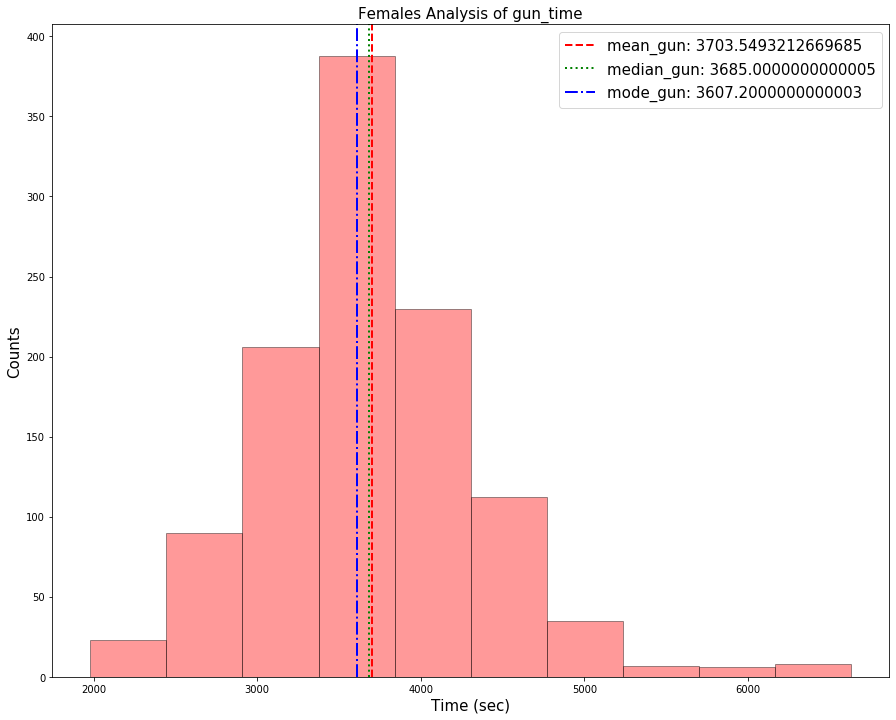

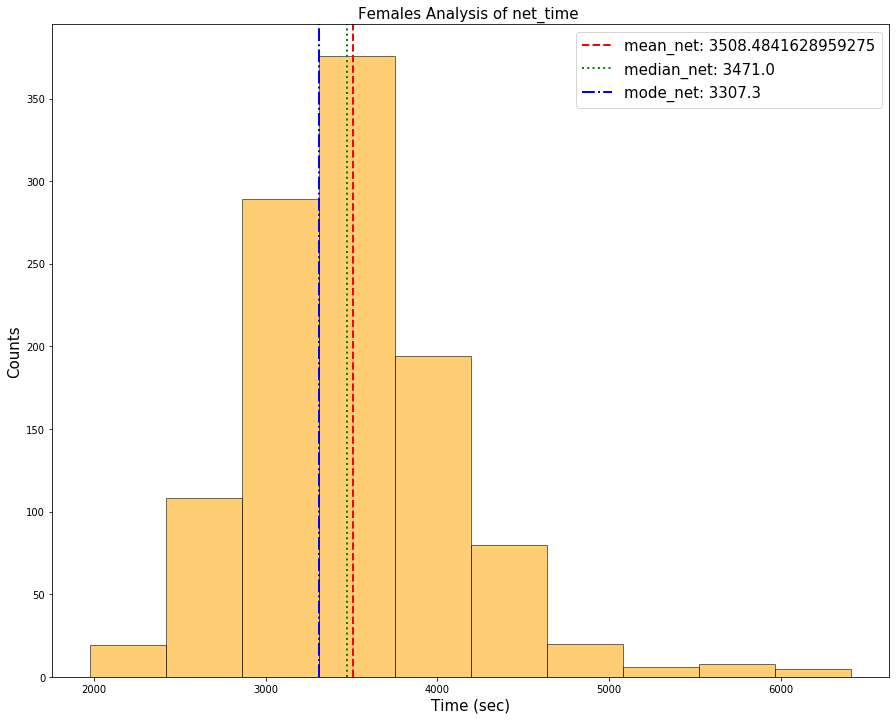

In [1167]:

counts, bins = np.histogram(final_df['gun_time'][final_df.gender == 'Females'], bins=20)
mode = dict(zip(bins, counts))
left_mode = list(sorted(mode.items(),key= lambda x:x[1]))[-1]
modez_gun = float(left_mode[0])

mean_gun = plt.axvline(final_df['gun_time'][final_df.gender == 'Females'].mean(), color = 'r', linestyle = 'dashed', linewidth = 2)
median_gun = plt.axvline(final_df['gun_time'][final_df.gender == 'Females'].median(), color = 'g', linestyle = 'dotted', linewidth = 2)
mode_gun = plt.axvline(modez_gun, color = 'b', linestyle = 'dashdot', linewidth = 2)


plt.rcParams ["figure.figsize"] = (15, 12) 
plt.hist(final_df['gun_time'][final_df.gender == 'Females'], alpha = 0.4, bins = 10, color = 'red', edgecolor = 'black')

plt.legend([mean_gun, median_gun, mode_gun], 
            [str('mean_gun: ') + str(final_df['gun_time'][final_df.gender == 'Females'].mean()), 
            str('median_gun: ')+str(final_df['gun_time'][final_df.gender == 'Females'].median()),
            str('mode_gun: ')+str(modez_gun)], fontsize = 15)

plt.title(str('Females') + str(" Analysis of gun_time"), fontsize = 15)

plt.xlabel('Time (sec)', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)


plt.show()


plt.hist(final_df['net_time'][final_df.gender == 'Females'], alpha = 0.55, bins = 10, color = 'orange', edgecolor = 'black')
plt.title(str('Females') + str(" Analysis of net_time "), fontsize = 15)

plt.xlabel('Time (sec)', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)




counts, bins = np.histogram(final_df['net_time'][final_df.gender == 'Females'], bins=20)
mode = dict(zip(bins, counts))
left_mode = list(sorted(mode.items(),key= lambda x:x[1]))[-1]
modez_net = float(left_mode[0])

mean_net = plt.axvline(final_df['net_time'][final_df.gender == 'Females'].mean(), color = 'r', linestyle = 'dashed', linewidth = 2)
median_net = plt.axvline(final_df['net_time'][final_df.gender == 'Females'].median(), color = 'g', linestyle = 'dotted', linewidth = 2)
mode_net = plt.axvline(modez_net, color = 'b', linestyle = 'dashdot', linewidth = 2)



plt.legend([mean_net, median_net, mode_net],
            [str('mean_net: ') + str(final_df['net_time'][final_df.gender == 'Females'].mean()), 
            str('median_net: ')+str(final_df['net_time'][final_df.gender == 'Females'].median()),
            str('mode_net: ')+str(modez_net)], fontsize = 15)

plt.show()




# Mean, Median, Mode Analysis Males

### Slightly different than the Females, the Males gun_time central tendency measurement indicates a much more central location of the mean, median. However, the mode > mean > median which suggests a slight left skew of the data. 

### Net time demonstrates a traditional right skew of central tendancy mean > median > mode.


### Note: Again, as in the Females analysis, the mode is calculated from the right edge of the most populated bin in a 20 bin histgram of the data



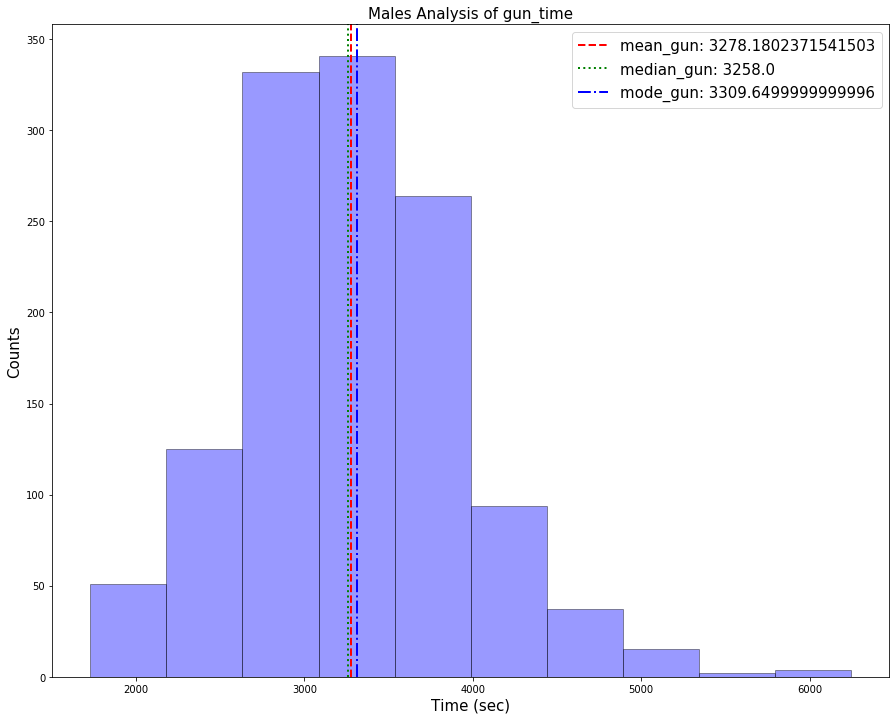

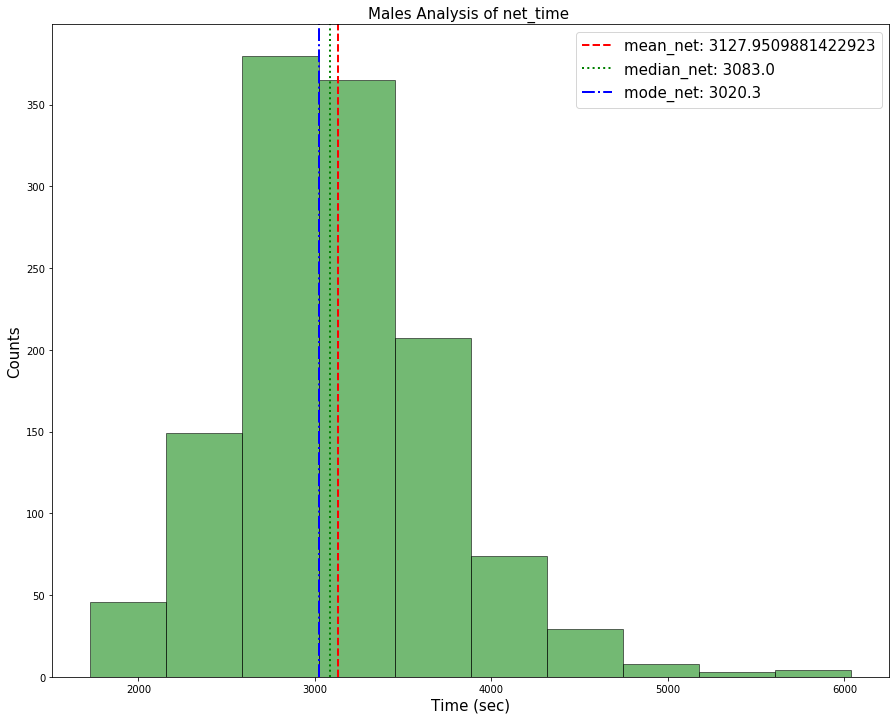

In [1168]:

counts, bins = np.histogram(final_df['gun_time'][final_df.gender == 'Males'], bins=20)
mode = dict(zip(bins, counts))
left_mode = list(sorted(mode.items(),key= lambda x:x[1]))[-1]
modez_gun = float(left_mode[0])

mean_gun = plt.axvline(final_df['gun_time'][final_df.gender == 'Males'].mean(), color = 'r', linestyle = 'dashed', linewidth = 2)
median_gun = plt.axvline(final_df['gun_time'][final_df.gender == 'Males'].median(), color = 'g', linestyle = 'dotted', linewidth = 2)
mode_gun = plt.axvline(modez_gun, color = 'b', linestyle = 'dashdot', linewidth = 2)


plt.rcParams ["figure.figsize"] = (15, 12) 
plt.hist(final_df['gun_time'][final_df.gender == 'Males'], alpha = 0.4, bins = 10, color = 'blue', edgecolor = 'black')

plt.xlabel('Time (sec)', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)

plt.legend([mean_gun, median_gun, mode_gun], 
            [str('mean_gun: ') + str(final_df['gun_time'][final_df.gender == 'Males'].mean()), 
            str('median_gun: ')+str(final_df['gun_time'][final_df.gender == 'Males'].median()),
            str('mode_gun: ')+str(modez_gun)], fontsize = 15)

plt.title(str('Males') + str(" Analysis of gun_time"), fontsize = 15)


plt.show()


plt.hist(final_df['net_time'][final_df.gender == 'Males'], alpha = 0.55, bins = 10, color = 'green', edgecolor = 'black')

plt.xlabel('Time (sec)', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)

plt.title(str('Males') + str(" Analysis of net_time "), fontsize = 15)




counts, bins = np.histogram(final_df['net_time'][final_df.gender == 'Males'], bins=20)
mode = dict(zip(bins, counts))
left_mode = list(sorted(mode.items(),key= lambda x:x[1]))[-1]
modez_net = float(left_mode[0])

mean_net = plt.axvline(final_df['net_time'][final_df.gender == 'Males'].mean(), color = 'r', linestyle = 'dashed', linewidth = 2)
median_net = plt.axvline(final_df['net_time'][final_df.gender == 'Males'].median(), color = 'g', linestyle = 'dotted', linewidth = 2)
mode_net = plt.axvline(modez_net, color = 'b', linestyle = 'dashdot', linewidth = 2)



plt.legend([mean_net, median_net, mode_net],
            [str('mean_net: ') + str(final_df['net_time'][final_df.gender == 'Males'].mean()), 
            str('median_net: ')+str(final_df['net_time'][final_df.gender == 'Males'].median()),
            str('mode_net: ')+str(modez_net)], fontsize = 15)

plt.show()




# Gun and Net Times Analyses

### As seen in the scatter below, net times contain much less variance than gun times, suggesting a more refined data collection method



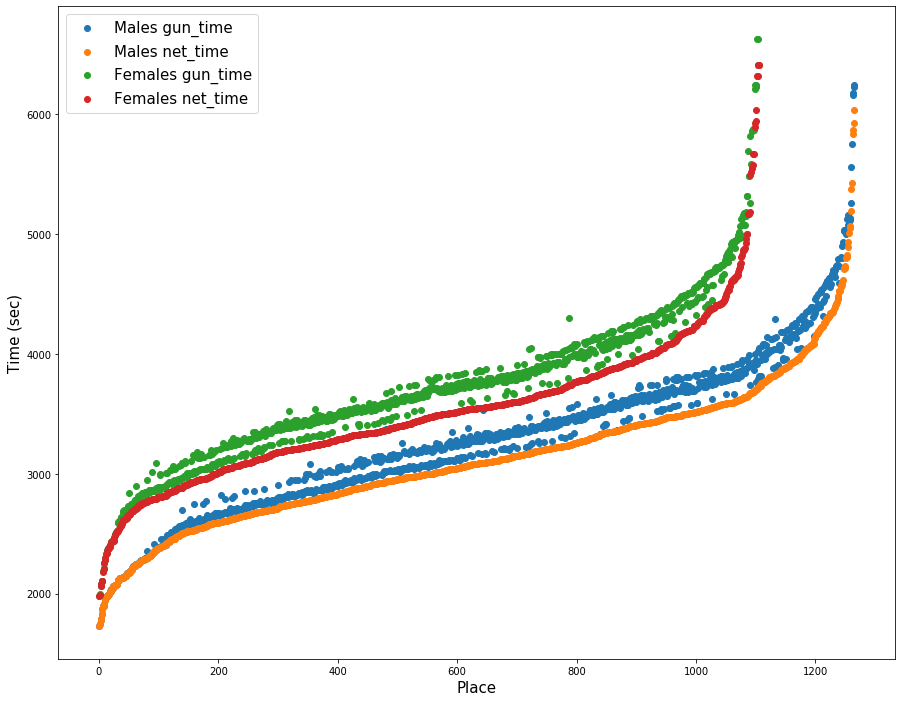

In [1169]:
plt.scatter(final_df.place[final_df.gender == 'Males'], final_df.gun_time[final_df.gender == 'Males'])
plt.scatter(final_df.place[final_df.gender == 'Males'], final_df.net_time[final_df.gender == 'Males'])
plt.scatter(final_df.place[final_df.gender == 'Females'], final_df.gun_time[final_df.gender == 'Females'])
plt.scatter(final_df.place[final_df.gender == 'Females'], final_df.net_time[final_df.gender == 'Females'])

plt.xlabel('Place', fontsize = 15)
plt.ylabel('Time (sec)', fontsize = 15)

plt.legend(['Males gun_time', 'Males net_time', 'Females gun_time', 'Females net_time'], loc = 'upper left', fontsize = 15)

# Indications of variance due to inaccuracies with gun_times. Additionally, Males overall had lower times in both categories

### Further analysis shows that there are 4 distinct groupings of gun time variance from net times for racers. This indicates that there is most likely a specified delay in the data collection of gun or net times. Additionally, there could also be 4 distinct data collectors that are a specified delay amount off from net times. 

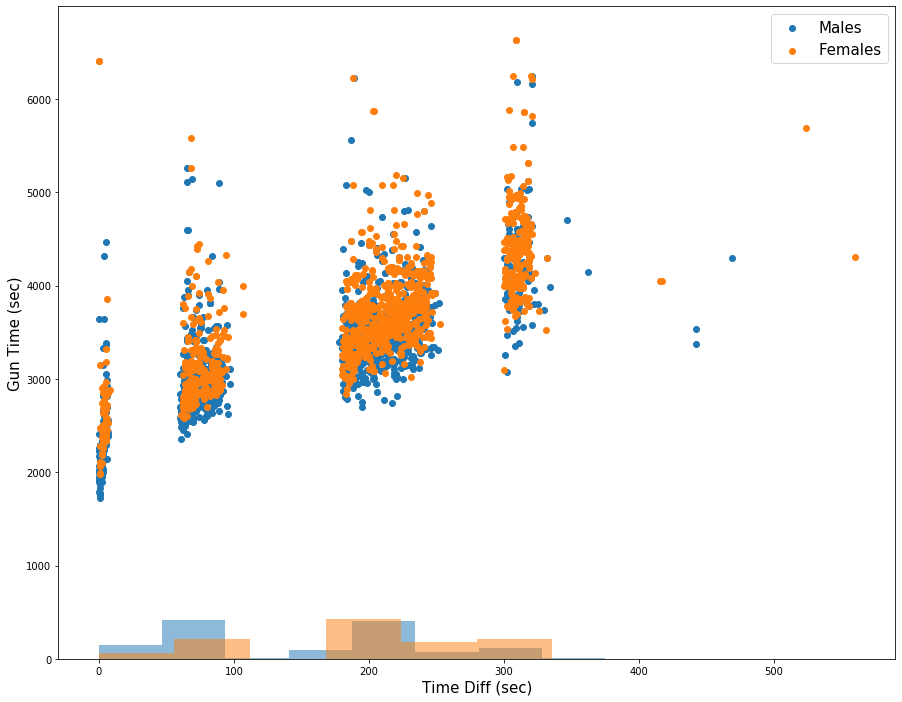

In [1170]:
genders = []
for i in final_df['gender'].unique():
    genders.append(i)
    plt.scatter(final_df.time_diff[final_df['gender'] == i], final_df.gun_time[final_df['gender'] == i])
    plt.hist(final_df.time_diff[final_df['gender'] == i], alpha = .5)
    
plt.xlabel('Time Diff (sec)', fontsize = 15)
plt.ylabel('Gun Time (sec)', fontsize = 15)

plt.legend(genders, fontsize = 15)

### Analysis of gun and net times by division indicates the afforementioned accuracy of net_time data collection and that groupings within each division are distributed almost evenly with pace. So, each division contains a somewhat evenly distributed amount of runners with respect to running pace

Text(0, 0.5, 'Gun and Net Time (sec)')

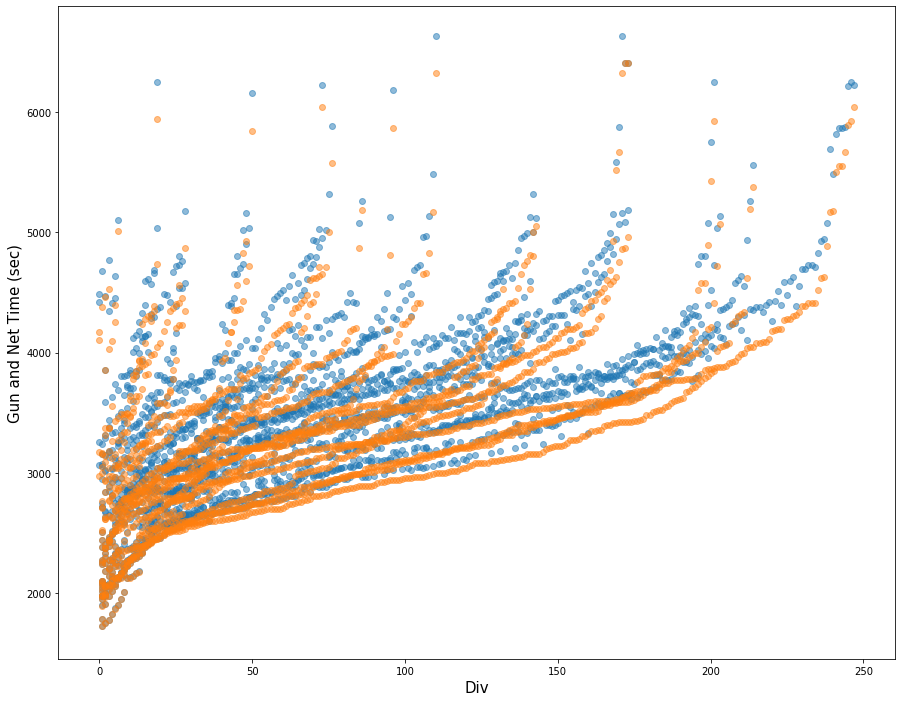

In [1171]:
plt.scatter(final_df['div'], final_df['gun_time'], alpha = .5)
plt.scatter(final_df['div'], final_df['net_time'], alpha = .5)

plt.xlabel('Div', fontsize = 15)
plt.ylabel('Gun and Net Time (sec)', fontsize = 15)


### Analysis of Average times by division indicates that times became larger in magnitudes overall as the division number grew

### Again, comparing the gun and net times, much less variance observed with net times thereby indicating a more precise time collection method

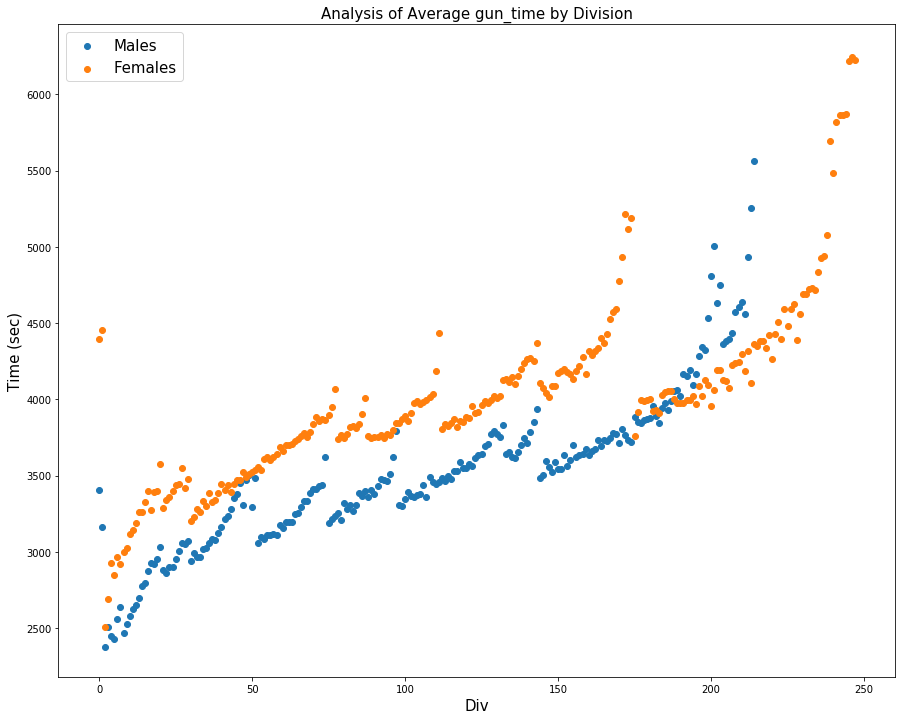

Text(0, 0.5, 'Time (sec)')

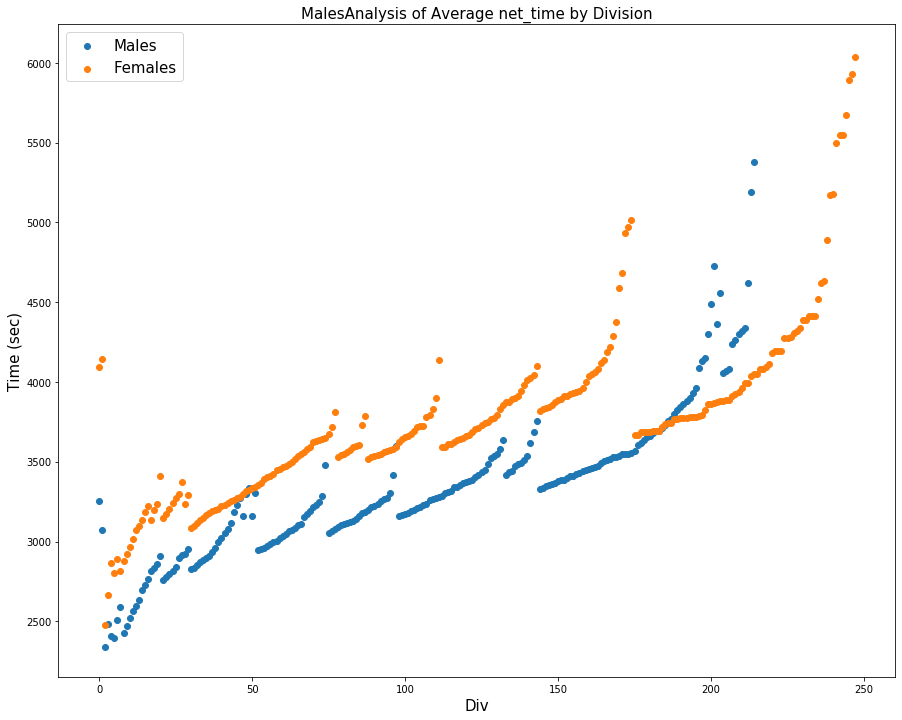

In [1174]:

plt.scatter(final_df['div'][final_df.gender == 'Males'].unique(), final_df[final_df.gender == 'Males'].groupby('div')['gun_time'].mean())

plt.scatter(final_df['div'][final_df.gender == 'Females'].unique(), final_df[final_df.gender == 'Females'].groupby('div')['gun_time'].mean())
plt.legend(['Males', 'Females'], fontsize = 15)
plt.title(str("Analysis of Average gun_time by Division"), fontsize = 15)

plt.xlabel('Div', fontsize = 15)
plt.ylabel('Time (sec)', fontsize = 15)

plt.show()


plt.scatter(final_df['div'][final_df.gender == 'Males'].unique(), final_df[final_df.gender == 'Males'].groupby('div')['net_time'].mean())

plt.scatter(final_df['div'][final_df.gender == 'Females'].unique(), final_df[final_df.gender == 'Females'].groupby('div')['net_time'].mean())
plt.legend(['Males', 'Females'], fontsize = 15)
plt.title(str('Males') + str("Analysis of Average net_time by Division"), fontsize = 15)

plt.xlabel('Div', fontsize = 15)
plt.ylabel('Time (sec)', fontsize = 15)


# State Level Analysis

### State Analyses of gun_time and net_time for Males and Females indicates that Males had lower average times across the board with the exception of a few states (PA and IL) 

### Note:' No State' indicates Kenya

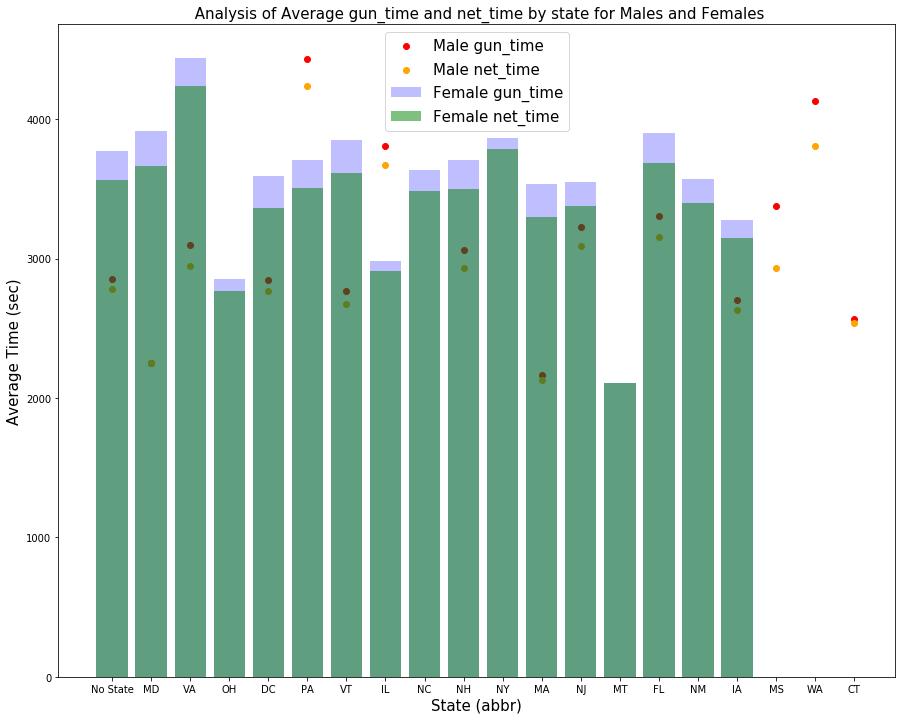

Text(0, 0.5, 'Count')

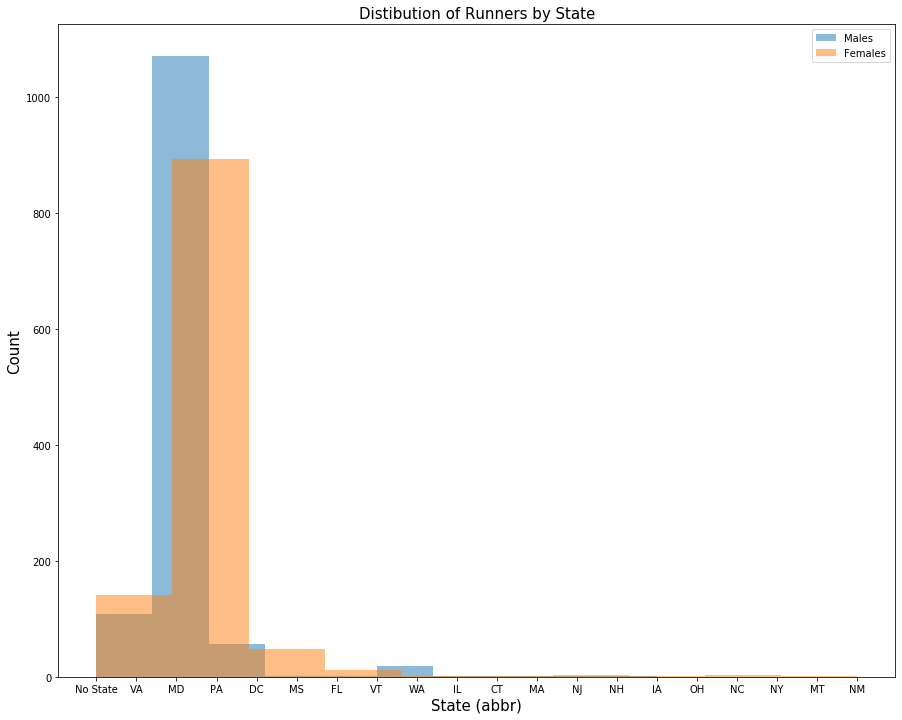

In [1194]:


plt.bar(final_df['state'][final_df.gender == 'Females'].unique(), final_df[final_df.gender == 'Females'].groupby('state')['gun_time'].mean(), alpha = .25, color = 'b')
plt.bar(final_df['state'][final_df.gender == 'Females'].unique(), final_df[final_df.gender == 'Females'].groupby('state')['net_time'].mean(), alpha = .5, color = 'g')


plt.scatter(final_df['state'][final_df.gender == 'Males'].unique(), final_df[final_df.gender == 'Males'].groupby('state')['gun_time'].mean(), color = 'r')
plt.scatter(final_df['state'][final_df.gender == 'Males'].unique(), final_df[final_df.gender == 'Males'].groupby('state')['net_time'].mean(), color = 'orange')
plt.legend(['Male gun_time', 'Male net_time', 'Female gun_time', 'Female net_time'], fontsize = 15, loc = 'best')
plt.title(str(" Analysis of Average gun_time and net_time by state for Males and Females"), fontsize = 15)

plt.xlabel('State (abbr)', fontsize = 15)
plt.ylabel('Average Time (sec)', fontsize = 15)

plt.show()

plt.hist(final_df['state'][final_df['gender'] == 'Males'], alpha = .5)
plt.hist(final_df['state'][final_df['gender'] == 'Females'], alpha = .5)

plt.title(str("Distibution of Runners by State"), fontsize = 15)

plt.legend(['Males','Females'])


plt.xlabel('State (abbr)', fontsize = 15)
plt.ylabel('Count', fontsize = 15)


# Chris Doe Analysis

Text(0, 0.5, 'Runner')

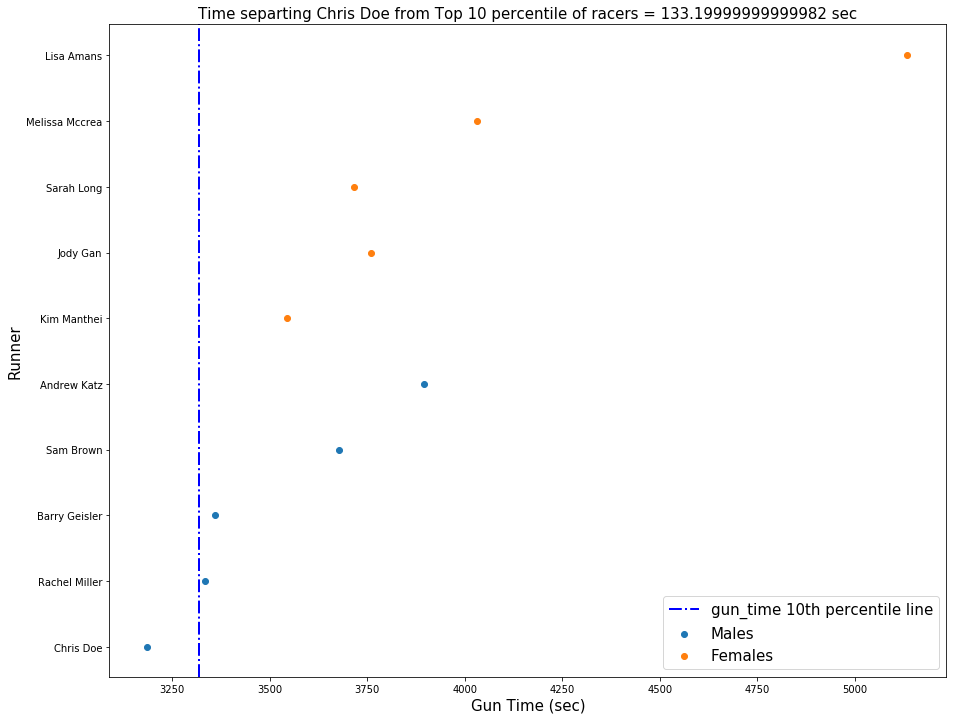

In [1177]:
chris_doe_div = float(final_df['div'][final_df['name'] == 'Chris Doe'])

gun_time_10 = final_df[final_df['div'] == chris_doe_div]['gun_time'].quantile(.10)


plt.scatter(final_df[(final_df['div'] == chris_doe_div)&(final_df['gender'] == 'Males')]['gun_time'], final_df[(final_df['div'] == chris_doe_div)&(final_df['gender'] == 'Males')]['name'])

plt.scatter(final_df[(final_df['div'] == chris_doe_div)&(final_df['gender'] == 'Females')]['gun_time'], final_df[(final_df['div'] == chris_doe_div)&(final_df['gender'] == 'Females')]['name'])

plt.axvline(gun_time_10, color = 'b', linestyle = 'dashdot', linewidth = 2)

plt.legend(['gun_time 10th percentile line','Males', 'Females'], fontsize = 15)

plt.title(str('Time separting Chris Doe from Top 10 percentile of racers = ') + str(gun_time_10 - float(final_df['gun_time'][final_df['name'] == 'Chris Doe']))+ str(' sec'), fontsize = 15)

plt.xlabel('Gun Time (sec)', fontsize = 15)
plt.ylabel('Runner', fontsize = 15)

In [1]:
import requests 
import pandas as pd
import json
import time
from bs4 import BeautifulSoup
import datetime
from datetime import date

today = date.today()
url = r'https://stocktwits.com/symbol/SPY'


#while True:
#    try:
#print("Update data:", datetime.datetime.now())
#sleep = 1 - datetime.datetime.now().time().minute % 1
#if sleep == 1:


page = requests.get(url)
response = BeautifulSoup(page.content, 'html.parser')
testing = response.find_all('script')
try:
    final = testing[8].contents[0][4131:5700]
    final = final[0:final.find('"type"')+31]
    test = test = '{' + final + '}'
    final_test = json.loads(test)

    final_1 = testing[8].contents[0]
    test_1 = final_1.find('"identifier"')
    final_1 = final_1[test_1:len(final_1)]
    final_final = final_1[0:final_1.find('"symbol"')+15]
    final_ext = json.loads('{'+final_final)
except:
    final = testing[8].contents[0][4134:5699]
    final = final[0:final.find('"type"')+31]
    test = test = '{' + final + '}'
    final_test = json.loads(test)

    final_1 = testing[8].contents[0]
    test_1 = final_1.find('"identifier"')
    final_1 = final_1[test_1:len(final_1)]
    final_final = final_1[0:final_1.find('"symbol"')+15]
    final_ext = '{'+final_final
    final_ext = json.loads('{'+final_final)



#try:
#    final_df = pd.read_csv('spy.csv')
#except:
#    final_df = pd.DataFrame()


#try:
#    extended_final = pd.read_csv('extended_hours.csv')
#except:
#    extended_final = pd.DataFrame()

final = pd.DataFrame(['SPY', final_test['trendingScore'], final_test['sentimentChange'], final_test['volumeChange'], final_test['priceData']['last']]).T
final['date'] = today
final['time'] = datetime.datetime.now().time()

final.columns = ['ticker', 'trend_score', 'sentiment_change', 'vol_change', 'last_price','date', 'time']
final_df = pd.concat([final_df, final])

final_df = final_df.loc[:, ~final_df.columns.str.contains('Unnamed')]
final_df.to_csv('spy.csv')


extended = pd.DataFrame()
tester = [float(final_ext['extendedHoursPrice']), today, datetime.datetime.now().time()]
final_extdended = pd.DataFrame(tester).T
final_extdended.columns = ['price', 'date', 'time']


extended_final = pd.concat([extended_final, final_extdended]).reset_index(drop = True)
extended_final = extended_final.loc[:, ~extended_final.columns.str.contains('Unnamed')]
#extended_final.to_csv('extended_hours.csv')


#print(final_df[len(final_df)-1:len(final_df)])
#print('')
#time.sleep(sleep * 15)
 #   except:
 #       pass
#else:
  #  time.sleep(sleep * 15)

JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

In [2]:
test

'{a":false},"symbol":"SPY","id":7271,"title":"SPDR S&P 500 ETF","aliases":[],"isFollowing":false,"watchlistCount":460697,"hasPricing":true,"exchange":"NYSEArca","sector":"Miscellaneous","industry":"InvestmentTrustsOrMutualFunds","logoUrl":"http://logos.xignite.com/AMEX/00030212.gif","trending":false,"trendingScore":-7.36812,"tradeStatus":"FRACTIONAL","sentimentChange":-0.49,"volumeChange":-1.89,"priceData":{"identifier":"SPY","open":361.8,"high":365.91,"low":357.04,"last":357.18,"lastSize":100,"volume":153711243,"previousClose":362.79,"previousCloseDate":"2022-09-29","percentChange":-1.546,"change":-5.61,"outcome":"Success","extendedHoursType":"PostMarket","extendedHoursPrice":357.8,"extendedHoursChange":0.62,"extendedHoursPercentChange":0.174,"extendedHoursDateTime":"2022-09-30 21:30:10","dateTime":"2022-09-30 20:00:00","type":"equity","symbol":"SPY"}}'